Extract feature from gTVDN (use method_eig)

Here I only use AD and HC data and following discussion today (on Dec 21, 2023), 

Here I use Mask matrix M(d x 7) to do dim reduction and do cpts on M^T X(t); 

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu

def _get_test_tb(res_df, base_grp_id=6):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    base = res_df["metric"][res_df["diagnosis"]==base_grp_id]
    grp_name = diag_lab_mapping[base_grp_id]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    diag_ix =  np.setdiff1d([1, 6], [base_grp_id])[0]
    DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
    ttest_res = ttest_ind(DS, base)
    ttest_res1 = mannwhitneyu(DS, base)
    effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb


In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [8]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");
num_rois = 246 # the BNA has 246 regions

# some parameters
yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);
# get the mask matrix
M = np.zeros((num_rois, 8));
# 0 is non-network roi
for net_ix in range(8):
    M[yeo_7nets_lab == net_ix, net_ix] = 1
# normalize
M = M/M.sum(axis=0, keepdims=1)

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485
num_seq = 8

8

In [9]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# only need AD and HC grp
sub_data_idxs = np.bitwise_or(diag_labs==1, diag_labs == 6);
diag_labs_sub = diag_labs[sub_data_idxs];
sex_labs_sub = sex_labs[sub_data_idxs];
mmse_scores_sub = mmse_scores[sub_data_idxs];

# Run gTVDN

In [10]:
save_dir = RES_ROOT/"gTVDN2grp_eig_proj7net_sc1"
if not save_dir.exists():
    save_dir.mkdir()

In [11]:
gtvdn_paras = edict()
# these two are most influential
gtvdn_paras.fct = 0.1
gtvdn_paras.lamb = 5e-5
# r is moderately influential
gtvdn_paras.r = 8
# not very important
gtvdn_paras.Lmin = 5
gtvdn_paras.MaxM = 20
gtvdn_paras.kappas = np.linspace(0.1, 4, 1000)
gtvdn_paras.T = 2

# new from gTVDN
gtvdn_paras.L = 1e2 # the  L1-ball projectoin radius
gtvdn_paras.num_ranks = 8 # the rank to keep when estimating the Amat for each data
gtvdn_paras.cutoff = 0.6
gtvdn_paras.Cs = np.array([100, 25, 10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.01])
gtvdn_paras.penalty = "l2"
gtvdn_paras.down_sample_rate = 2;



In [12]:
save_pkl(save_dir/"paras.pkl", gtvdn_paras, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/paras.pkl


## Get data

In [13]:
# get all ts data and divide them into different group
# note the ts are preprocessed (detrend and resample)
from collections import defaultdict as ddict
all_data = []
for sub_ix in range(num_sps):
    ts = M.T @ _load_data(sub_ix+1)[:num_rois]
    ts = _preprocess_ts(ts);
    all_data.append(ts)
all_data = np.array(all_data);

# only choose 2 grps
all_data = all_data[sub_data_idxs];

## Bspline

In [14]:
from gTVDN.gtvdn_utils import get_bspline_est
time_span = np.linspace(0, gtvdn_paras.T, all_data[0].shape[-1])
dXXmats = {}
dXmats, Xmats = get_bspline_est(np.array(all_data), time_span, gtvdn_paras.lamb, n_jobs=20);
dXXmats["dXmats"] = dXmats
dXXmats["Xmats"] = Xmats;
    
save_pkl(save_dir/"dXXmats.pkl", dXXmats, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1456/1456 [00:01<00:00, 878.11it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/dXXmats.pkl


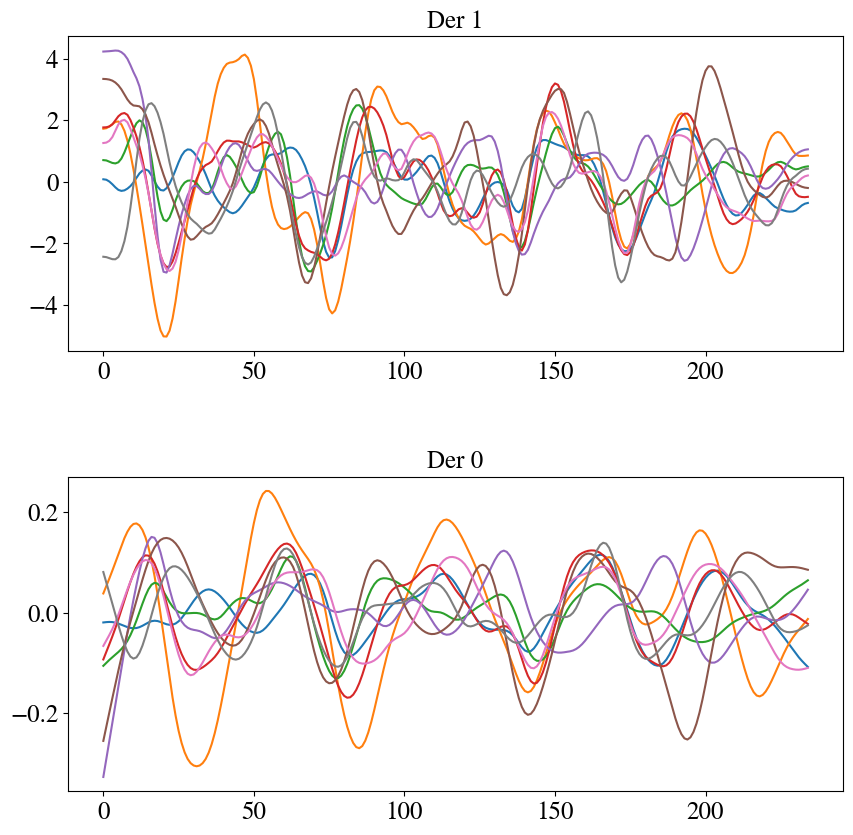

In [15]:
sub_ix = 0 
dXmat = dXmats[sub_ix]
Xmat = Xmats[sub_ix];

plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Der 1")
for roi_ix in range(num_seq):
    plt.plot(dXmat[roi_ix])
plt.subplot(212)
plt.title("Der 0")
for roi_ix in range(num_seq):
    plt.plot(Xmat[roi_ix])

## Estimate Amats

In [16]:
from gTVDN.gtvdn_utils import get_Amats
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
time_span = np.linspace(0, gtvdn_paras.T, dXXmats["Xmats"].shape[-1]);


Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/dXXmats.pkl


In [17]:
dXmats = dXXmats["dXmats"];
Xmats = dXXmats["Xmats"];
Amats = get_Amats(dXmats[:], Xmats[:], time_span, 
        downrate=gtvdn_paras.down_sample_rate, 
        fct=gtvdn_paras.fct, 
        nRks=gtvdn_paras.num_ranks, 
        is_stack=False, n_jobs=20);
save_pkl(save_dir/"Amats.pkl", np.array(Amats), is_force=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1132.62it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/Amats.pkl


## Dim reduction

In [18]:
from gTVDN.gtvdn_utils import get_newdata
Amats = load_pkl(save_dir/"Amats.pkl");
dXXmats =load_pkl(save_dir/"dXXmats.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/Amats.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/dXXmats.pkl


In [19]:
Amat = Amats.mean(axis=0);
dXmats = dXXmats["dXmats"]
Xmats = dXXmats["Xmats"];

In [21]:
red_res = get_newdata(dXmats, Xmats, Amat, gtvdn_paras.r, True);

In [22]:
save_pkl(save_dir/"red_res.pkl", red_res, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/red_res.pkl


### DP

In [23]:
from gTVDN.gtvdn_det_eig import dyna_prog

In [24]:
def _run_fn(sub_ix):
    res = dyna_prog(red_res["ndXmats"][sub_ix], 
                    red_res["nXmats"][sub_ix], 
                    gtvdn_paras.kappas[0], 
                    red_res["kpidxs"], 
                    Lmin=gtvdn_paras.Lmin, 
                    MaxM=gtvdn_paras.MaxM,
                    is_full=True, 
                    showProgress=False
                   )
    return res
with Parallel(n_jobs=20) as parallel:
    cpts = parallel(delayed(_run_fn)(sub_ix) for sub_ix 
                    in tqdm(range(len(diag_labs_sub)),  total=len(diag_labs_sub)))
    
save_pkl(save_dir/"cpts.pkl", cpts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [02:48<00:00,  1.08it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/cpts.pkl


# Analysis

## Kappa find

In [25]:

save_dir = RES_ROOT/"gTVDN2grp_eig_proj7net_sc1/"
gtvdn_paras = load_pkl(save_dir/"paras.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/paras.pkl


In [26]:
from gTVDN.gtvdn_post import update_kp
cpts = load_pkl(save_dir/"cpts.pkl");
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
red_res = load_pkl(save_dir/"red_res.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/cpts.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/dXXmats.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/gTVDN2grp_eig_proj7net_sc1/red_res.pkl


In [27]:
res = cpts[0];
_, cur_r, n = red_res["nXmats"].shape
cpts_allkp = []
for kp in tqdm(gtvdn_paras.kappas):
    allkp = np.array([update_kp(kp, cpt.U0, n, cur_r, gtvdn_paras.MaxM) for cpt in cpts])
    cpts_allkp.append(allkp)
cpts_allkp = np.array(cpts_allkp);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1116.47it/s]


1.5873873873873874 14.851648351648352


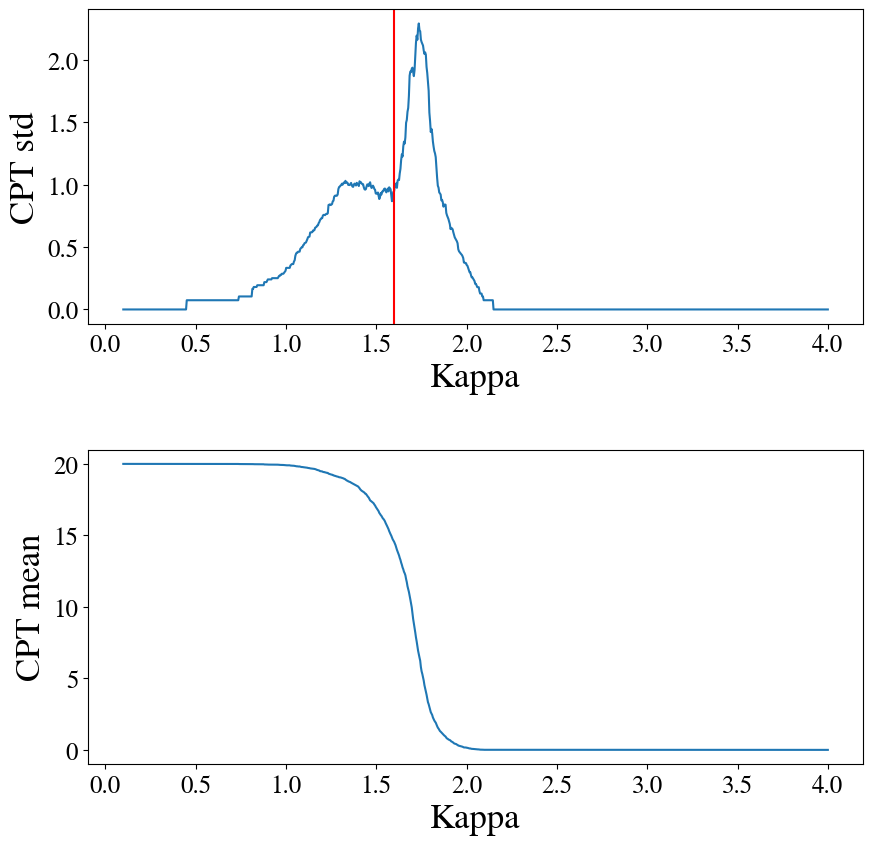

In [28]:
# HC grp only to select kappa
cpts_std = cpts_allkp[:, diag_labs_sub==6].std(axis=1)
cpts_mean = cpts_allkp[:, diag_labs_sub==6].mean(axis=1);
cpts_std = cpts_allkp[:, :].std(axis=1)
cpts_mean = cpts_allkp[:, :].mean(axis=1);
plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.plot(gtvdn_paras.kappas, cpts_std)
plt.ylabel("CPT std")
plt.axvline(x=1.60, color="red")
plt.xlabel("Kappa")
plt.subplot(212)
plt.plot(gtvdn_paras.kappas, cpts_mean)
plt.ylabel("CPT mean")
plt.xlabel("Kappa");

sel_idx = np.bitwise_and(cpts_mean>=2, cpts_mean<=18);
sel_kp = gtvdn_paras.kappas[sel_idx][np.argmin(cpts_std[sel_idx])]
print(sel_kp, cpts_mean[np.argmin(np.abs(gtvdn_paras.kappas-sel_kp))])

# I select kp at 1.65
#sel_kp = gtvdn_paras.kappas[np.argmin(np.abs(gtvdn_paras.kappas-1.65))]

In [29]:
# Update kappa
#sel_kp = 1.65
ncpts_sel = np.array([update_kp(sel_kp, cpt.U0, n, cur_r, gtvdn_paras.MaxM) for cpt in cpts]);
cpts_sel = [cur_cpt.chgMat[cur_ncpt-1, :cur_ncpt] 
                       for cur_ncpt, cur_cpt 
                       in zip(ncpts_sel, cpts)];
dwells_sel = [np.diff(np.concatenate([[0], cpt_sel, [235]]))*ac_time/235
                       for cpt_sel
                       in cpts_sel];
maxdwell = np.array([dwell.max() for dwell in dwells_sel]);



In [30]:
res_df = pd.DataFrame({
    "metric": ncpts_sel, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.292,0.157
(non-param) AD vs HC,0.374,0.157


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,14.926829,0.871787,13.0,14.0,15.0,16.0,17.0
HC,100.0,14.790000,0.868006,13.0,14.0,15.0,15.0,17.0


In [31]:
res_df = pd.DataFrame({
    "metric": maxdwell, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.760,-0.046
(non-param) AD vs HC,0.706,-0.046


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,44.397509,7.062318,33.021277,39.212766,43.340426,47.468085,80.489362
HC,100.0,44.723191,7.227453,35.085106,39.212766,43.340426,47.468085,80.489362


## Reestimate lambda for each segment

In [32]:
from gTVDN.gtvdn_post import est_eigvals

In [33]:
eig_vals = []
for sub_ix in range(len(diag_labs_sub)):
    eig_vals.append(est_eigvals(cpts_sel[sub_ix], red_res["ndXmats"][sub_ix], 
                                red_res["nXmats"][sub_ix], red_res["kpidxs"]));

### Mean

In [34]:
# get mean dwell time for each subject at each U, 
# if no segment for a specific U, 0
# The membership is based on the max abs of ws for each segment
allsub_dwell_eachU = np.zeros((len(diag_labs_sub), gtvdn_paras.r));

for sub_ix in range(len(diag_labs_sub)):
    eig_val = eig_vals[sub_ix]
    dwells = dwells_sel[sub_ix]
    Uidxs = np.argmax(np.abs(eig_val), axis=0)
    for u_ix in range(gtvdn_paras.r):
        allsub_dwell_eachU[sub_ix, u_ix] = dwells[Uidxs==u_ix].mean() if (Uidxs==u_ix).sum() > 0 else 0


/tmp/ipykernel_69019/2718810608.py:21: RuntimeWarning: invalid value encountered in double_scalars
  effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)


Test,Pval,Effect size
AD vs HC,nan,nan
(non-param) AD vs HC,1.000,nan


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HC,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


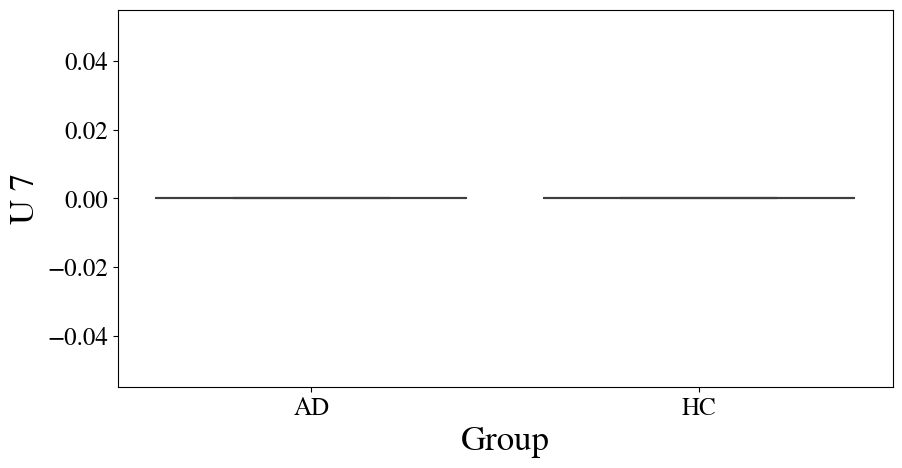

In [43]:
u_ix = 7
res_df = pd.DataFrame({
    "metric": allsub_dwell_eachU[:, u_ix],
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)

sns.boxplot(data=res_df, x="diagnosis1", y="metric", showfliers=False)
plt.xlabel("Group")
plt.ylabel(f"U {u_ix}")

display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

### Max

In [44]:
# get max dwell time for each subject at each U, 
# if no segment for a specific U, 0
# The membership is based on the max abs of ws for each segment
allsub_dwell_eachU = np.zeros((len(diag_labs_sub), gtvdn_paras.r));

for sub_ix in range(len(diag_labs_sub)):
    eig_val = eig_vals[sub_ix]
    dwells = dwells_sel[sub_ix]
    Uidxs = np.argmax(np.abs(eig_val), axis=0)
    for u_ix in range(gtvdn_paras.r):
        allsub_dwell_eachU[sub_ix, u_ix] = dwells[Uidxs==u_ix].max() if (Uidxs==u_ix).sum() > 0 else 0


/tmp/ipykernel_69019/2718810608.py:21: RuntimeWarning: invalid value encountered in double_scalars
  effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)


Test,Pval,Effect size
AD vs HC,nan,nan
(non-param) AD vs HC,1.000,nan


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HC,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


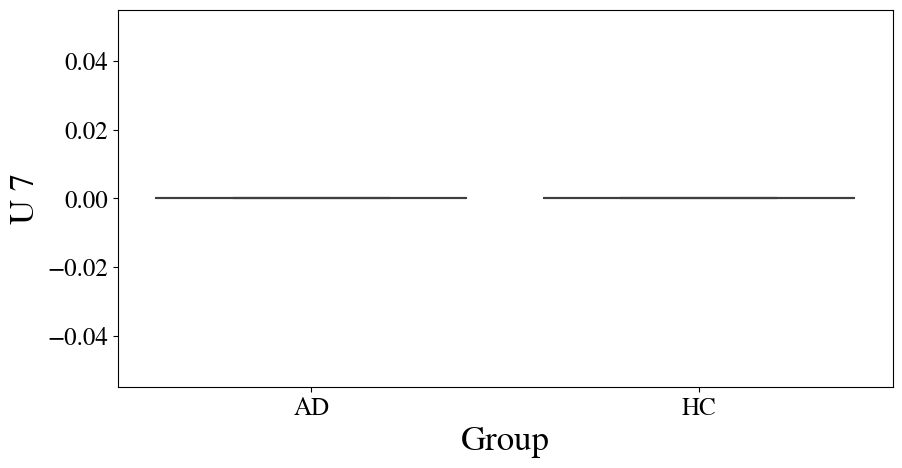

In [52]:
u_ix = 7
res_df = pd.DataFrame({
    "metric": allsub_dwell_eachU[:, u_ix],
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)

sns.boxplot(data=res_df, x="diagnosis1", y="metric", showfliers=False)
plt.xlabel("Group")
plt.ylabel(f"U {u_ix}")

display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()